# Final Project
---

For your final assignment, you are tasked with building a predictive model for the movie ratings in the MovieLens 1M dataset. You may download the dataset here: https://grouplens.org/datasets/movielens/1m/. This is a dataset containing 1 million movie ratings, with side information about the users and movies. 

You will write an essay detailing your model implementation and results on this dataset. First, you will split the data into a 80% training data set and a 20% held-out test data set. Then, you will propose a model to fit to the data for this problem and implement it yourself. Please explain why you chose to use your proposed model. You should use the ideas taught in the class to inform your analysis. Explain any model selection procedures you use in this assignment. Finally, report the test set MSE of your model's predictions on the test set ratings and conclude your essay properly. There is no page minimum for the essay, but there is a maximum of 10 pages (using regular formatting like 2.5cm margins, 12pt font, A4 size. The page limit includes any graphs / figures / etc.). Your writing must be coherent and organized. If you are unsure how to organize a paper, please follow this example for what a proper essay will look like: https://jgscott.github.io/teaching/writeups/write_ups/. 

For this assignment, you must submit a Jupyter notebook containing your code. You must ensure the code you submit in this assignment runs properly and can generate all the figures and results you mention in your essay. **YOU MAY NOT USE PREWRITTEN PACKAGES FOR FITTING THE DATA TO THE MODEL, MEANING YOU MUST WRITE YOUR OWN IMPLEMENTATION**. You may reuse code that you have previously written, or code from your tutorial sessions. However, you are permitted to use any of the functions available in numpy, scipy, pandas or pytorch, This includes the optimization and linear algebra packages in the previously named packages. Additionally, you can use some of the preprocessing packages in sklearn, if you think you will need it. You may not use any of the test data to help train the model. You should write your code in the form of a neatly organized object, like you have done in your previous HW assignments. 

Your submission for this assignment will be your Jupyter notebook containing your code and a .pdf file containing your essay. Due to the tight deadlines with the final marks, **NO EXTENSIONS WILL BE GRANTED**. Students are reminded to acquaint themselves with the HKU policies on academic dishonesty in order to avoid any problems with plagiarism.

Your implementation may only use the packages below:

In [1]:
# YOU MAY ONLY USE THE FOLLOWING PACKAGES
import numpy as np
import scipy as sp
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import math

You must use the following code to load the data and split the ratings matrix into a training and test set.

In [3]:
# DO NOT MODIFY ANY OF THE CODE IN THIS BLOCK
rating_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movie_names  = ['MovieID', 'Title', 'Genres']
user_names   = ['UserID','Gender','Age','Occupation','Zip-code']
ratings      = pd.read_csv("ratings.dat", delimiter="::", names=rating_names, engine="python", encoding='latin-1')
movies       = pd.read_csv("movies.dat", delimiter="::", names=movie_names, engine="python", encoding='latin-1')
users        = pd.read_csv("users.dat", delimiter="::", names=user_names, engine="python", encoding='latin-1')
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=0)

You may inspect the data using the head() function.

In [4]:
train_ratings.head()

,UserID,MovieID,Rating,Timestamp
37222,253,3418,3,976688190
145484,935,1954,5,976669675
345747,2029,3034,4,974670594
358642,2098,356,4,974652753
562909,3463,1240,4,967174968


In [5]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


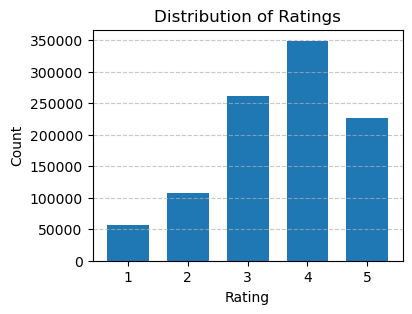

In [7]:
plt.figure(figsize=(4, 3))
plt.hist(ratings['Rating'], bins=np.arange(0.5, 6), align='mid', rwidth=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(np.arange(1, 6, step=1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ratings Distribution: Left-Skewed
A left-skewed distribution for ratings suggests that users tend to give higher ratings. This could be because users are more likely to rate movies they liked (or watched completely), leading to a prevalence of higher ratings. The skew might also reflect a general satisfaction with the movies available, or it might indicate that users are typically optimistic in their ratings.

In this scenario, the mean rating is likely lower than the median rating, reflecting the impact of a smaller number of low ratings pulling the distribution's tail to the left.

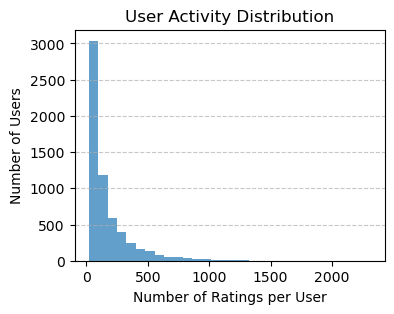

In [8]:
user_activity = ratings.groupby('UserID').size()

plt.figure(figsize=(4, 3))
plt.hist(user_activity, bins=30, alpha=0.7)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Number of Ratings per User: Long-tailed
When the number of ratings per user has a high peak near 0, it indicates that many users rate only a few movies. This is common in many online platforms where engagement levels vary widely among users. The long, thin tail suggests that while most users rate only a few movies, there are a few highly active users who rate many more.

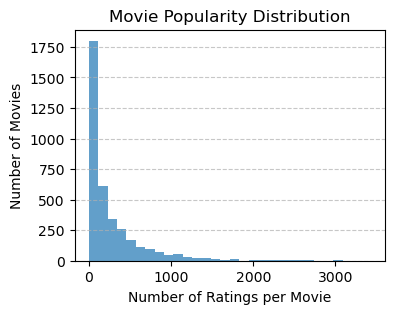

In [9]:
movie_popularity = ratings.groupby('MovieID').size()

plt.figure(figsize=(4, 3))
plt.hist(movie_popularity, bins=30, alpha=0.7)
plt.title('Movie Popularity Distribution')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Number of Ratings per Movie: Long-tailed
Similar to user activity, the number of ratings per movie being high near 0 with a long, narrow tail indicates that many movies receive few ratings, while a small number of movies are rated very frequently. This might suggest a concentration of popularity among certain movies, potentially blockbuster or highly marketed films, while many other movies remain relatively obscure.

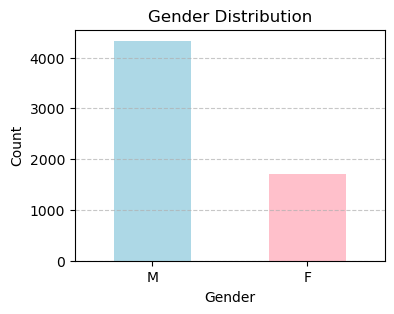

In [10]:
gender_counts = users['Gender'].value_counts()

plt.figure(figsize=(4, 3))
gender_counts.plot(kind='bar', color=['lightblue', 'pink'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

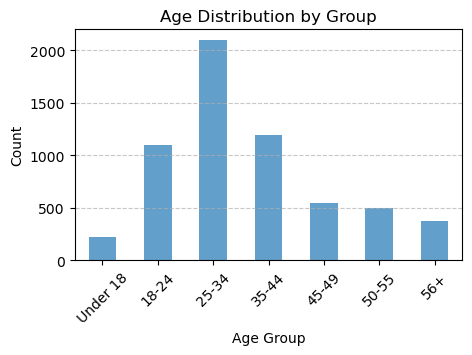

In [11]:
# set age range
age_ranges = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

# occurrences of each age group
age_counts = users['Age'].value_counts().sort_index()
age_counts.index = [age_ranges[age] for age in age_counts.index]

plt.figure(figsize=(5, 3))
age_counts.plot(kind='bar', alpha=0.7)
plt.title('Age Distribution by Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to fit longer text
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Age Distribution: Right-Skewed
A right-skewed distribution for age suggests that there are more younger users than older ones, but there is a significant number of older users that extend the tail of the distribution to the right. This could indicate that while the platform is popular among younger users, it still maintains appeal among older demographics, albeit to a lesser extent.

In statistical terms, a right-skewed distribution often has a mean that is greater than the median.

In [19]:
# merge datasets
df = pd.merge(ratings, users, on='UserID', how='left')
df = pd.merge(df, movies, on='MovieID', how='left')

# preprocess data
# one-hot encoding of genres
df['Genres'] = df['Genres'].apply(lambda x: x.split('|'))
df = df.join(df['Genres'].str.join('|').str.get_dummies())

# reindex UserID, MovieID, Gender & Occupation columns
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()

df['UserID'] = user_encoder.fit_transform(df['UserID'])
df['MovieID'] = movie_encoder.fit_transform(df['MovieID'])
df['Gender'] = gender_encoder.fit_transform(df['Gender'])
df['Occupation'] = occupation_encoder.fit_transform(df['Occupation'])

# normalise age
age_scaler = MinMaxScaler()
df['Age'] = age_scaler.fit_transform(df[['Age']])

# add average ratings column
average_ratings = df.groupby('MovieID')['Rating'].mean().reset_index()
average_ratings.columns = ['MovieID', 'AverageRating']
df = df.merge(average_ratings, on='MovieID', how='left')

# add number of ratings column
num_ratings = df.groupby('MovieID')['Rating'].count().reset_index()
num_ratings.columns = ['MovieID', 'NumRatings']
df = df.merge(num_ratings, on='MovieID', how='left')

df = df.drop(columns=["Genres"])

# split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

train_df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Action,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,AverageRating,NumRatings
37222,252,3186,3,976688190,0,0.436364,11,97370,Thelma & Louise (1991),1,...,0,0,0,0,0,0,0,0,3.680311,1417
145484,934,1774,5,976669675,1,0.618182,14,60538,Rocky (1976),1,...,0,0,0,0,0,0,0,0,3.943313,1129
345747,2028,2820,4,974670594,0,0.436364,12,10011,Robin Hood (1973),0,...,0,0,0,0,0,0,0,0,3.743440,343
358642,2097,346,4,974652753,1,0.618182,20,48067,Forrest Gump (1994),0,...,0,0,0,1,0,0,1,0,4.087967,2194
562909,3462,1148,4,967174968,1,0.436364,15,80301,"Terminator, The (1984)",1,...,0,0,0,0,1,1,0,0,4.152050,2098


In [18]:
# list of genres after one-hot encoding
columns = df.columns

genre_columns = [col for col in columns if col not in ['UserID', 'MovieID', 'Rating', 'Timestamp', 'Age', 'Occupation', 'Zip-code', 'Title', 'Gender', 'Genres', 'AverageRating', 'NumRatings']]
num_genres = len(genre_columns)

print("Number of genres:", num_genres)
print("List of genres:", genre_columns)

Number of genres: 18
List of genres: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [14]:
class MovieDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['UserID'].values, dtype=torch.int64)
        self.movies = torch.tensor(df['MovieID'].values, dtype=torch.int64)
        self.user_features = torch.tensor(df[['Age', 'Gender', 'Occupation']].values, dtype=torch.float32)
        self.movie_features = torch.tensor(df[['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
                                               'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                                               'Sci-Fi', 'Thriller', 'War', 'Western', 'AverageRating', 'NumRatings']].values, dtype=torch.float32)
        self.ratings = torch.tensor(df['Rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.user_features[idx], self.movie_features[idx], self.ratings[idx]

class MovieRecommender(nn.Module):
    def __init__(self, num_users, num_movies, user_feature_size=3, movie_feature_size=20, embedding_size=50, dropout_rate=0.5):
        super(MovieRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        input_size = 2 * embedding_size + user_feature_size + movie_feature_size
        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )

    def forward(self, user_ids, movie_ids, user_features, movie_features):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedded, movie_embedded, user_features, movie_features], dim=-1)
        output = self.fc_layers(x)
        return output.squeeze()

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for users, movies, user_features, movie_features, ratings in loader:
        users, movies, user_features, movie_features, ratings = users.to(device), movies.to(device), user_features.to(device), movie_features.to(device), ratings.to(device)

        optimizer.zero_grad()
        predictions = model(users, movies, user_features, movie_features)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for users, movies, user_features, movie_features, ratings in loader:
            users, movies, user_features, movie_features, ratings = users.to(device), movies.to(device), user_features.to(device), movie_features.to(device), ratings.to(device)
            
            predictions = model(users, movies, user_features, movie_features)
            loss = criterion(predictions, ratings)
            total_loss += loss.item()
    return total_loss / len(loader)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# initialize datasets
train_dataset = MovieDataset(train_df)
test_dataset = MovieDataset(test_df)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# initialise MovieRecommender object
model = MovieRecommender(df['UserID'].nunique(), df['MovieID'].nunique(), user_feature_size=3, movie_feature_size=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# train
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')

# model evaluation
test_loss = evaluate(model, test_loader, criterion, device)
test_rmse = math.sqrt(test_loss)
print(f'Test RMSE: {test_rmse:.4f}')

Using cpu device
Epoch 1: Train Loss = 3.9154, Test Loss = 1.2427
Epoch 2: Train Loss = 1.5992, Test Loss = 0.9651
Epoch 3: Train Loss = 1.1386, Test Loss = 0.8785
Epoch 4: Train Loss = 0.9618, Test Loss = 0.8462
Epoch 5: Train Loss = 0.8916, Test Loss = 0.8400
Epoch 6: Train Loss = 0.8706, Test Loss = 0.8338
Epoch 7: Train Loss = 0.8613, Test Loss = 0.8406
Epoch 8: Train Loss = 0.8552, Test Loss = 0.8291
Epoch 9: Train Loss = 0.8521, Test Loss = 0.8234
Epoch 10: Train Loss = 0.8503, Test Loss = 0.8200
Test RMSE: 0.9055


In [17]:
def predict_ratings_for_user(user_id, num_movies, model, device):
    user_ids = torch.tensor([user_id] * num_movies, dtype=torch.int64).to(device)
    movie_ids = torch.tensor(list(range(num_movies)), dtype=torch.int64).to(device)
    user_features = torch.zeros(num_movies, 3).to(device)
    movie_features = torch.zeros(num_movies, 20).to(device)

    # get predictions
    model.eval()
    with torch.no_grad():
        ratings_pred = model(user_ids, movie_ids, user_features, movie_features)
        ratings_pred = ratings_pred.cpu().numpy()

    return ratings_pred

user_id = 1
num_movies = df['MovieID'].nunique()  # total number of movies
ratings_pred = predict_ratings_for_user(user_id, num_movies, model, device)

# top 10 movies with highest ratings
top_movies_indices = ratings_pred.argsort()[-10:][::-1]
top_movies_ratings = ratings_pred[top_movies_indices]

print("Top 10 Movie Recommendations:")
for idx, rating in zip(top_movies_indices, top_movies_ratings):
    print(f"MovieID: {idx}, Predicted Rating: {rating:.2f}")

Top 10 Movie Recommendations:
MovieID: 2698, Predicted Rating: 4.45
MovieID: 708, Predicted Rating: 4.45
MovieID: 1066, Predicted Rating: 4.38
MovieID: 1839, Predicted Rating: 4.36
MovieID: 2309, Predicted Rating: 4.34
MovieID: 689, Predicted Rating: 4.30
MovieID: 1133, Predicted Rating: 4.29
MovieID: 1122, Predicted Rating: 4.29
MovieID: 843, Predicted Rating: 4.28
MovieID: 2816, Predicted Rating: 4.26
